In [18]:
# packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import calplot as cp
import folium
from folium.plugins import HeatMapWithTime
from urllib.request import urlopen
import json
import plotly.express as px

In [19]:
pd.options.mode.copy_on_write = True

In [20]:
cols_to_keep = [
    'family',
    'genus',
    'species',
    'locality',
    'coordinateUncertaintyInMeters',
    'decimalLatitude',
    'decimalLongitude',
    'eventDate',
    'month',
    'year'
]

In [21]:
# Specify the correct delimiter and handle bad lines (tab separated file)
df = pd.read_csv('./resources/DOF-observations-threathened-and-rare-species-1998-2025.csv', usecols=cols_to_keep, sep='\t', on_bad_lines='skip')

In [22]:
# remove 2025, as the year is not completed yet
df = df[df['year'] != 2025]

# Preview the first few rows to verify the structure
df.head()

,family,genus,species,locality,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,eventDate,month,year
0,Threskiornithidae,Platalea,Platalea leucorodia,Bygholm Vejle,57.04859,9.08802,2510.0,2002-05-12,5,2002
1,Pandionidae,Pandion,Pandion haliaetus,Skærsø Plantage,56.23806,10.68577,2240.0,2001-06-13,6,2001
2,Anatidae,Cygnus,Cygnus cygnus,Harboslette,57.09517,8.78545,1660.0,2001-11-16,11,2001
3,Anatidae,Mergus,Mergus merganser,Haderslev Dam,55.23635,9.44826,2370.0,2001-03-18,3,2001
4,Anatidae,Cygnus,Cygnus cygnus,Værnengene,55.85446,8.23863,4060.0,2002-03-14,3,2002


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2544444 entries, 0 to 2598653
Data columns (total 10 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   family                         object 
 1   genus                          object 
 2   species                        object 
 3   locality                       object 
 4   decimalLatitude                float64
 5   decimalLongitude               float64
 6   coordinateUncertaintyInMeters  float64
 7   eventDate                      object 
 8   month                          int64  
 9   year                           int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 213.5+ MB


In [24]:
# only keep the species that are part of the Novama program
species_to_keep = set([
    "Ichthyaetus melanocephalus",
    "Ciconia ciconia",
    "Ciconia nigra",
    "Circus pygargus",
    "Pandion haliaetus",
    "Aquila chrysaetos",
    "Haliaeetus albicilla",
    "Aegolius funereus",
    "Asio flammeus",
    "Falco peregrinus",
    "Anthus campestris"
])

df_novama = df[df["species"].isin(species_to_keep)]
#df_novama.head()
df_novama.info()

<class 'pandas.core.frame.DataFrame'>
Index: 616832 entries, 1 to 2598643
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   family                         616832 non-null  object 
 1   genus                          616832 non-null  object 
 2   species                        616832 non-null  object 
 3   locality                       616393 non-null  object 
 4   decimalLatitude                616832 non-null  float64
 5   decimalLongitude               616832 non-null  float64
 6   coordinateUncertaintyInMeters  616832 non-null  float64
 7   eventDate                      616832 non-null  object 
 8   month                          616832 non-null  int64  
 9   year                           616832 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 51.8+ MB


In [26]:
species_to_commonname = {
    'Aegolius funereus': 'Boreal owl',
    'Anthus campestris': 'Tawny pipit',
    'Asio flammeus': 'Short-eared owl',
    'Aquila chrysaetos': 'Golden eagle',
    'Ciconia ciconia': 'White stork',
    'Ciconia nigra': 'Black stork',
    'Circus pygargus': "Montagu's harrier",
    'Falco peregrinus': 'Peregrine falcon',
    'Haliaeetus albicilla': 'White-tailed eagle',
    'Ichthyaetus melanocephalus': 'Mediterranean gull',
    'Pandion haliaetus': 'Osprey',
}

# add a new column commonName with the english commonName of the birds
# fillna handles unknown species, if there are any
df_novama['commonName'] = df_novama['species'].map(species_to_commonname).fillna('Unknown species')
df_novama.head()

,family,genus,species,locality,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,eventDate,month,year,commonName
1,Pandionidae,Pandion,Pandion haliaetus,Skærsø Plantage,56.23806,10.68577,2240.0,2001-06-13,6,2001,Osprey
10,Accipitridae,Circus,Circus pygargus,Egebæk,55.28405,8.72183,960.0,2003-06-24,6,2003,Montagu's harrier
18,Accipitridae,Haliaeetus,Haliaeetus albicilla,Holmegårds Mose EF-lok. 91,55.29329,11.82678,5000.0,2002-08-18,8,2002,White-tailed eagle
24,Falconidae,Falco,Falco peregrinus,"Klydesøen, Kalvebod Fælled",55.58507,12.52259,5000.0,2002-09-09,9,2002,Peregrine falcon
40,Falconidae,Falco,Falco peregrinus,Nørrestrand,55.87815,9.87592,2420.0,2002-12-17,12,2002,Peregrine falcon


In [ ]:
# check if mapping went OK or if there are any unknown species
df_novama['commonName'].unique()

array(['Osprey', "Montagu's harrier", 'White-tailed eagle',
       'Peregrine falcon', 'Short-eared owl', 'White stork',
       'Golden eagle', 'Mediterranean gull', 'Black stork', 'Boreal owl',
       'Tawny pipit'], dtype=object)

In [28]:

df_yrs = df_novama.value_counts('year')
print(f"year with most registered threathened species: {df_yrs.idxmax()}. Count: {df_yrs.max()}")
print(f"year with least registered threathened species: {df_yrs.idxmin()}. Count: {df_yrs.min()}")

year with most registered threathened species: 2024. Count: 47772
year with least registered threathened species: 1999. Count: 3416


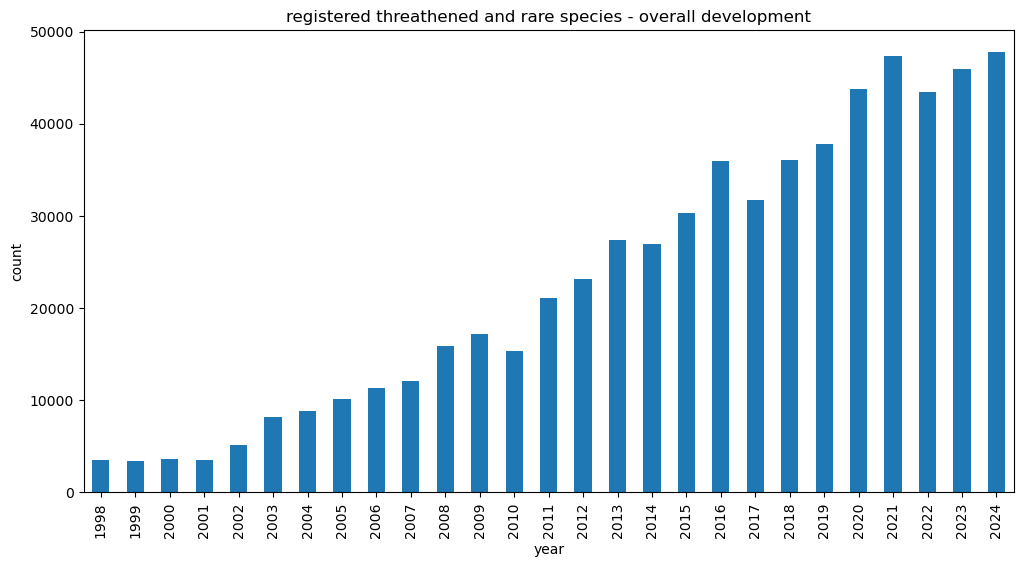

In [29]:
df_yrs = df_yrs.sort_index()

plt.figure(figsize=(12, 6))
df_yrs.plot(kind='bar')
plt.xlabel("year")
plt.ylabel("count")
plt.title("registered threathened and rare species - overall development")
plt.show()

In [31]:
species_yearly = df_novama.groupby(['year', 'commonName']).size().unstack()
species_yearly = species_yearly.fillna(0.0)
species_yearly.head(20)

commonName,Black stork,Boreal owl,Golden eagle,Mediterranean gull,Montagu's harrier,Osprey,Peregrine falcon,Short-eared owl,Tawny pipit,White stork,White-tailed eagle
year,,,,,,,,,,,
1998,2.0,0.0,62.0,60.0,133.0,1611.0,512.0,101.0,2.0,125.0,887.0
1999,8.0,0.0,71.0,84.0,191.0,1588.0,628.0,180.0,0.0,113.0,553.0
2000,5.0,0.0,99.0,83.0,321.0,1504.0,816.0,187.0,1.0,218.0,426.0
2001,5.0,0.0,77.0,79.0,265.0,1228.0,835.0,151.0,0.0,116.0,721.0
2002,4.0,0.0,178.0,134.0,315.0,1611.0,1413.0,325.0,3.0,126.0,1003.0
2003,11.0,1.0,370.0,209.0,350.0,2492.0,1946.0,541.0,0.0,309.0,1908.0
2004,27.0,0.0,370.0,169.0,454.0,2699.0,2105.0,495.0,0.0,273.0,2181.0
2005,0.0,0.0,394.0,176.0,492.0,3094.0,2653.0,538.0,7.0,179.0,2639.0
2006,4.0,0.0,279.0,264.0,632.0,2592.0,3348.0,546.0,4.0,330.0,3368.0


In [57]:
sum_pattern = species_yearly.sum()

print("Overall pattern - least to most observed overall time")
print(sum_pattern.sort_values())


Overall pattern - least to most observed overall time
commonName
Tawny pipit              182.0
Boreal owl               549.0
Black stork             1823.0
Mediterranean gull     15435.0
Golden eagle           15462.0
White stork            18320.0
Montagu's harrier      19024.0
Short-eared owl        20687.0
Osprey                102807.0
Peregrine falcon      114395.0
White-tailed eagle    308148.0
dtype: float64


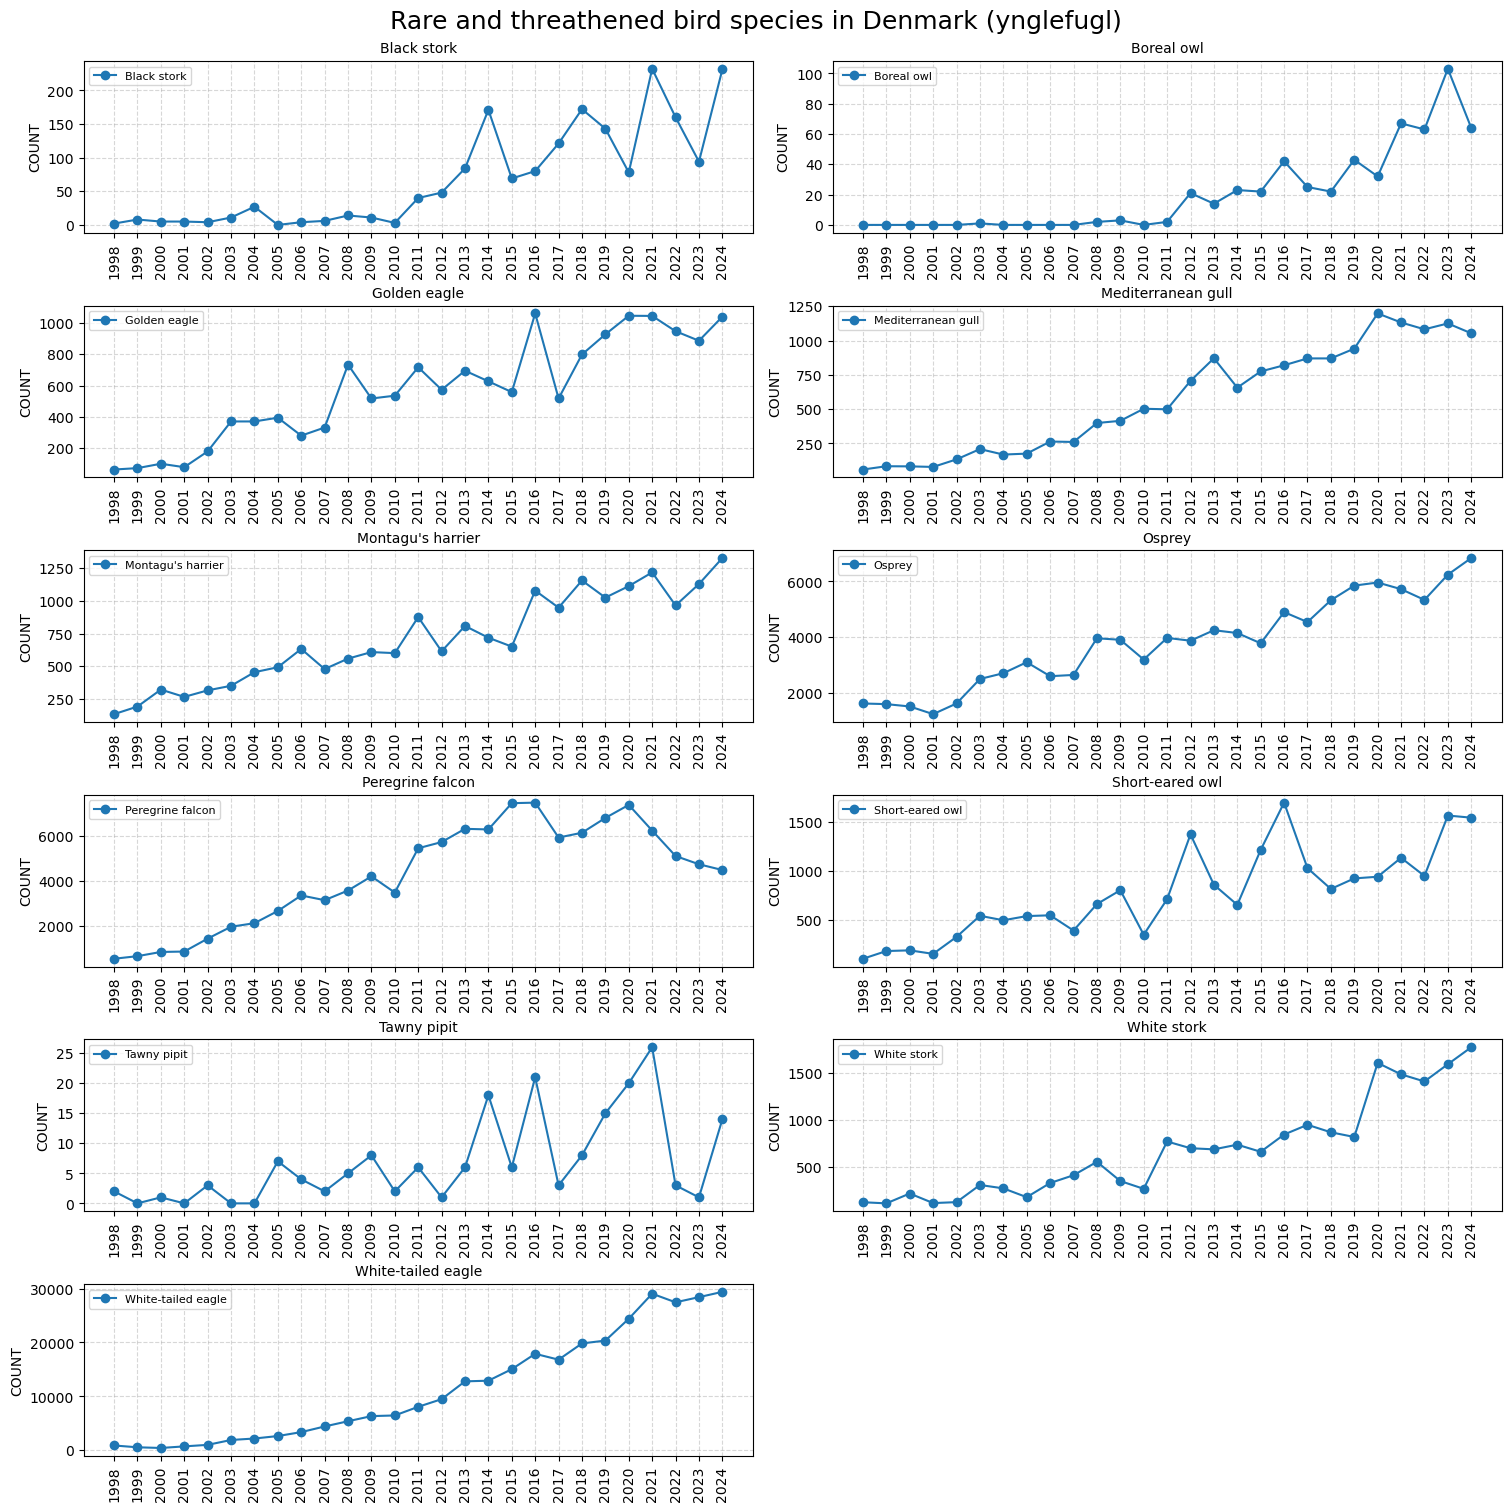

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,15), constrained_layout=True)
axes = axes.flatten()

for i, specie in enumerate(species_yearly.columns):
    axes[i].plot(species_yearly.index, species_yearly[specie], marker='o', label=specie)
    axes[i].set_title(specie, fontsize=10)
    axes[i].set_ylabel("COUNT")
    axes[i].set_xticks(ticks=np.arange(1998, 2025), labels=np.arange(1998, 2025), rotation=90)
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].legend(fontsize=8)

# delete last subplot
fig.delaxes(axes[len(axes) - 1])

plt.suptitle("Rare and threathened bird species in Denmark (ynglefugl)", fontsize=18)
plt.show()

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

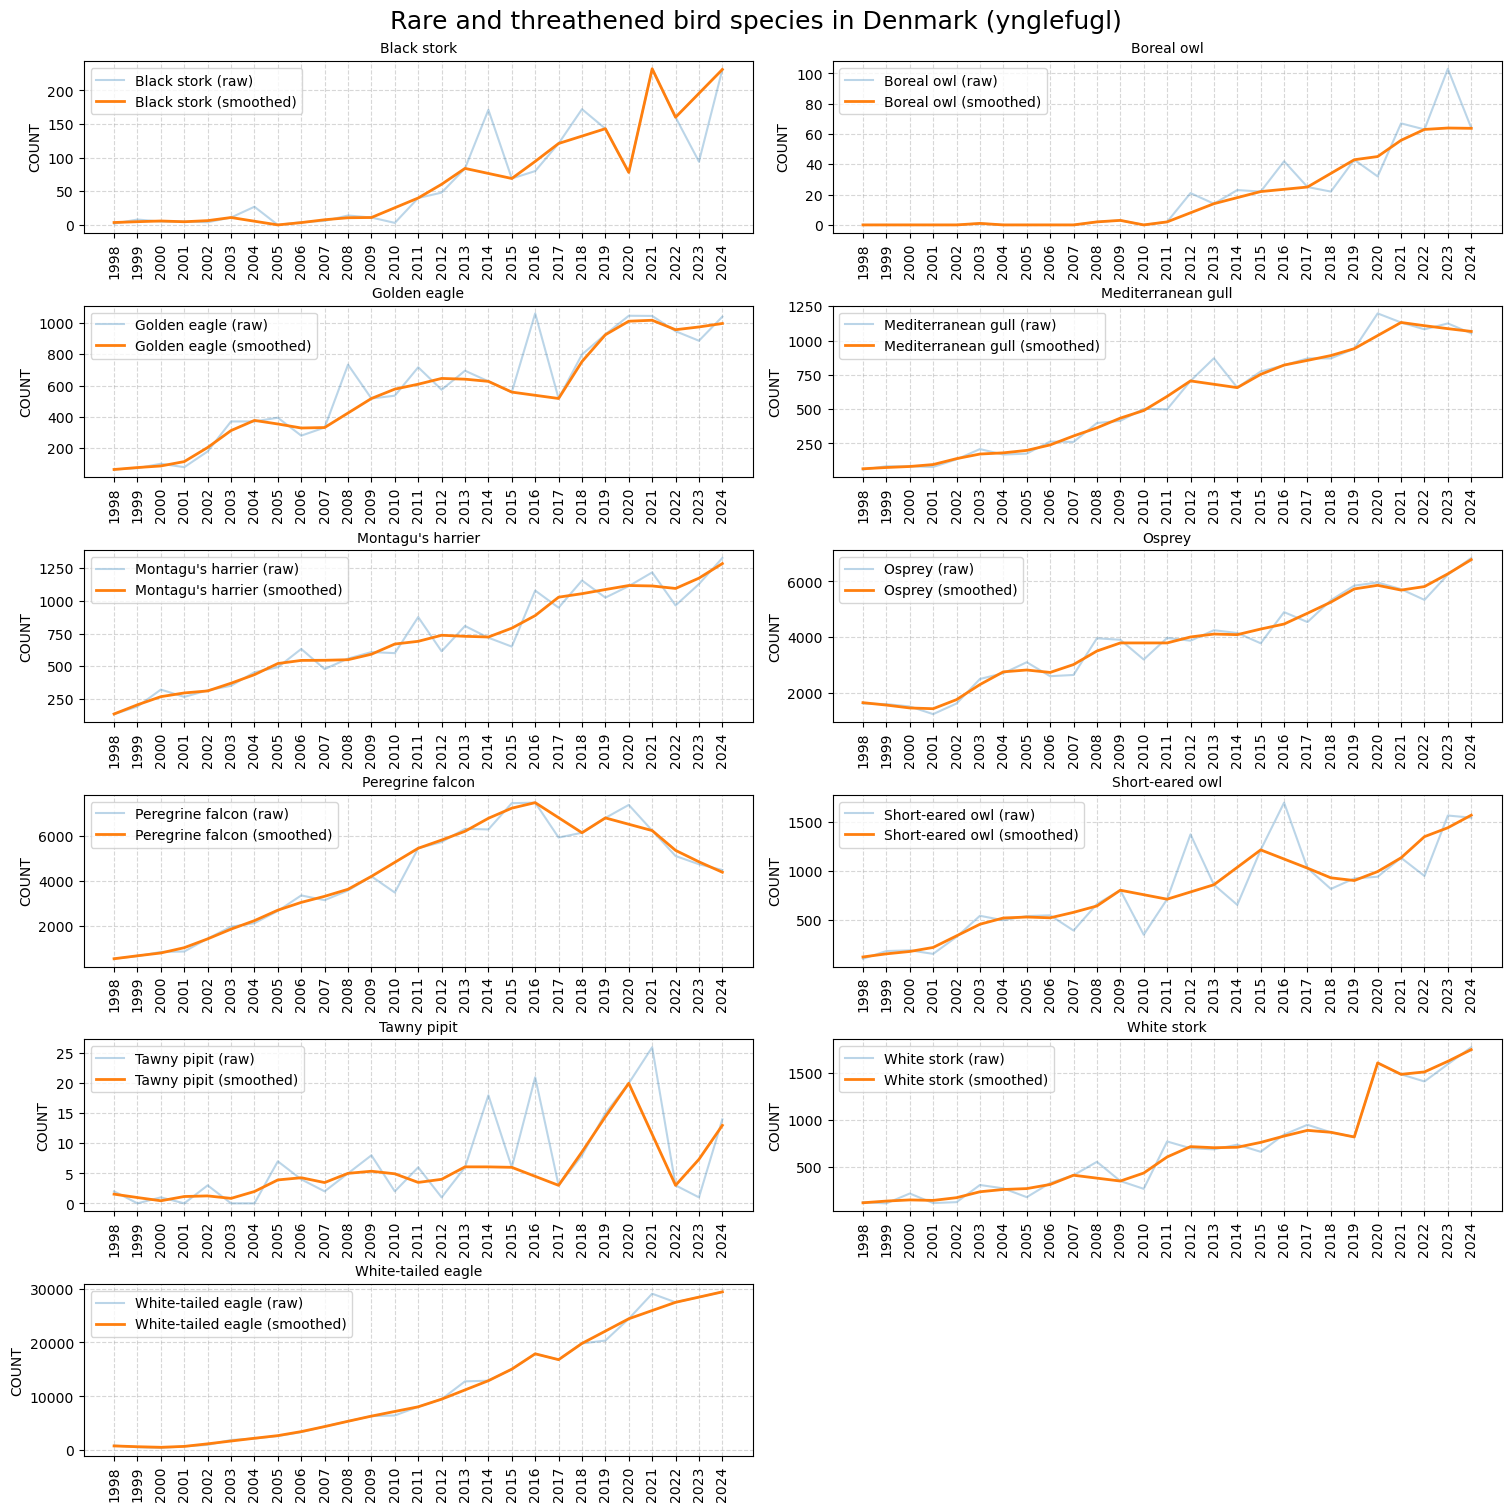

In [ ]:

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,15), constrained_layout=True)
axes = axes.flatten()

for i, specie in enumerate(species_yearly.columns):
    smoothed = lowess(species_yearly[specie], species_yearly.index, frac=0.2)

    axes[i].plot(species_yearly.index, species_yearly[specie], alpha=0.3, label=f"{specie} (raw)")
    # LOWESS smoothing
    axes[i].plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, label=f"{specie} (smoothed)")

    axes[i].set_title(specie, fontsize=10)
    axes[i].set_ylabel("COUNT")
    axes[i].set_xticks(ticks=np.arange(1998, 2025), labels=np.arange(1998, 2025), rotation=90)
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].legend()

# delete last subplot
fig.delaxes(axes[len(axes) - 1])

plt.suptitle("Rare and threathened bird species in Denmark (ynglefugl)", fontsize=18)
plt.show()


In [97]:
df_novama.head(5)

,family,genus,species,locality,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,eventDate,month,year,commonName
1,Pandionidae,Pandion,Pandion haliaetus,Skærsø Plantage,56.23806,10.68577,2240.0,2001-06-13,6,2001,Osprey
10,Accipitridae,Circus,Circus pygargus,Egebæk,55.28405,8.72183,960.0,2003-06-24,6,2003,Montagu's harrier
18,Accipitridae,Haliaeetus,Haliaeetus albicilla,Holmegårds Mose EF-lok. 91,55.29329,11.82678,5000.0,2002-08-18,8,2002,White-tailed eagle
24,Falconidae,Falco,Falco peregrinus,"Klydesøen, Kalvebod Fælled",55.58507,12.52259,5000.0,2002-09-09,9,2002,Peregrine falcon
40,Falconidae,Falco,Falco peregrinus,Nørrestrand,55.87815,9.87592,2420.0,2002-12-17,12,2002,Peregrine falcon
